In [62]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
# import tensorflow_datasets as tfds
import pandas as pd

tf.random.set_seed(29)

In [63]:
import scipy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [64]:
df = pd.read_csv('train.csv', dtype={'Id': str})
df['filename'] = 'images/' + df['Id'] + '.jpg'
df['imagename'] = df['Id'] + '.jpg'
df.head()

,Id,label,filename,imagename
0,0560,glass,images/0560.jpg,0560.jpg
1,4675,cup,images/4675.jpg,4675.jpg
2,0875,glass,images/0875.jpg,0875.jpg
3,4436,spoon,images/4436.jpg,4436.jpg
4,8265,plate,images/8265.jpg,8265.jpg


In [65]:
train_cutoff = int(len(df) * 0.6)
full_train_cutoff = int(len(df) * 0.8)

train_df = df[:train_cutoff]
val_df = df[train_cutoff:full_train_cutoff]
test_df = df[full_train_cutoff:]

In [66]:
train_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='label',
    target_size=(256, 256),
    batch_size=16,
)

val_datagen = ImageDataGenerator()

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='label',
    target_size=(256, 256),
    batch_size=16,
)

Found 3335 validated image filenames belonging to 6 classes.
Found 1112 validated image filenames belonging to 6 classes.


In [67]:
num_classes = 6

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomRotation(0.5),
  tf.keras.layers.RandomZoom(0.5),
  tf.keras.layers.RandomContrast(0.5),
  tf.keras.layers.RandomBrightness(0.5)
])


model = tf.keras.models.Sequential([
  tf.keras.Input(shape=(256, 256, 3)),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(8, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),

  tf.keras.layers.Dense(num_classes)
])

In [68]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 254, 254, 8)       224       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 16)      1168      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 62, 62, 16)       0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 61504)           

In [69]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

In [70]:
from keras.callbacks import EarlyStopping

# early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, mode='min')

history = model.fit(
  train_generator,
  validation_data=val_generator,
  epochs=4,
  # callbacks=[early_stopping]
)

Epoch 1/4
209/209 [==============================] - 70s 330ms/step - loss: 1.6228 - accuracy: 0.3586 - val_loss: 1.4155 - val_accuracy: 0.4424
Epoch 2/4
209/209 [==============================] - 69s 331ms/step - loss: 1.0971 - accuracy: 0.5943 - val_loss: 1.1121 - val_accuracy: 0.5845
Epoch 3/4
209/209 [==============================] - 81s 389ms/step - loss: 0.6172 - accuracy: 0.7889 - val_loss: 1.2205 - val_accuracy: 0.5638
Epoch 4/4
209/209 [==============================] - 77s 367ms/step - loss: 0.2840 - accuracy: 0.9160 - val_loss: 1.2571 - val_accuracy: 0.5998


In [71]:
test_datagen = ImageDataGenerator()

test_generator = val_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='label',
    target_size=(256, 256),
    batch_size=16,
)

Found 1112 validated image filenames belonging to 6 classes.


In [72]:
results = model.evaluate_generator(test_generator)
print("test loss, test acc:", results)

/var/folders/04/sr5x2zqn3rn38vjxrzd96c040000gn/T/ipykernel_55692/2236055841.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  results = model.evaluate_generator(test_generator)


test loss, test acc: [1.2736963033676147, 0.6097122430801392]


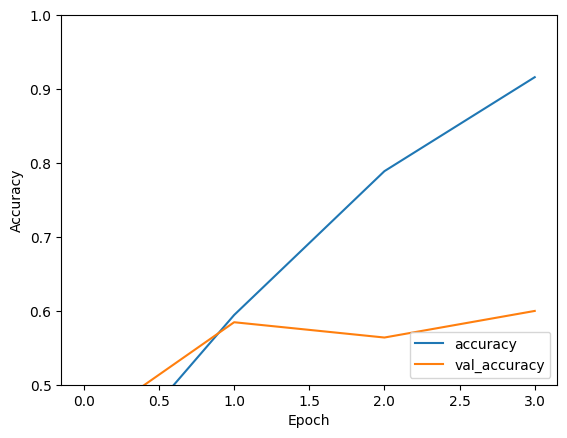

In [73]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')